# Image Denoising Using U-Net

## Unzip Input Data

In [ ]:
!unzip shoes.zip

## Import Necessary Libraries

In [58]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transforms import SaltAndPepper
from scipy.ndimage import gaussian_filter
import math

## Import Data

In [59]:
noise_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    SaltAndPepper(0.07)
])

In [60]:
train_dataset = datasets.ImageFolder(
    root="train", transform=noise_transform
)

test_dataset = datasets.ImageFolder(
    root="test", transform=noise_transform
)

In [61]:
num_workers = 1
batch_size = 64
valid_size = 0.2
train_length = len(train_dataset)
indices=list(range(train_length))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(valid_idx)

noisy_train_loader = DataLoader(
    train_dataset, num_workers=num_workers, batch_size=batch_size, sampler=train_sampler
)
noisy_validation_loader = DataLoader(
    train_dataset, num_workers=num_workers, batch_size=batch_size, sampler=validation_sampler
)
noisy_test_loader = DataLoader(
    test_dataset, shuffle=True, num_workers=num_workers, batch_size=batch_size
)

In [62]:
noise_dataiter = iter(noisy_train_loader)
data = next(noise_dataiter)
(noise_imgs, normal_imgs), noise_labels = data

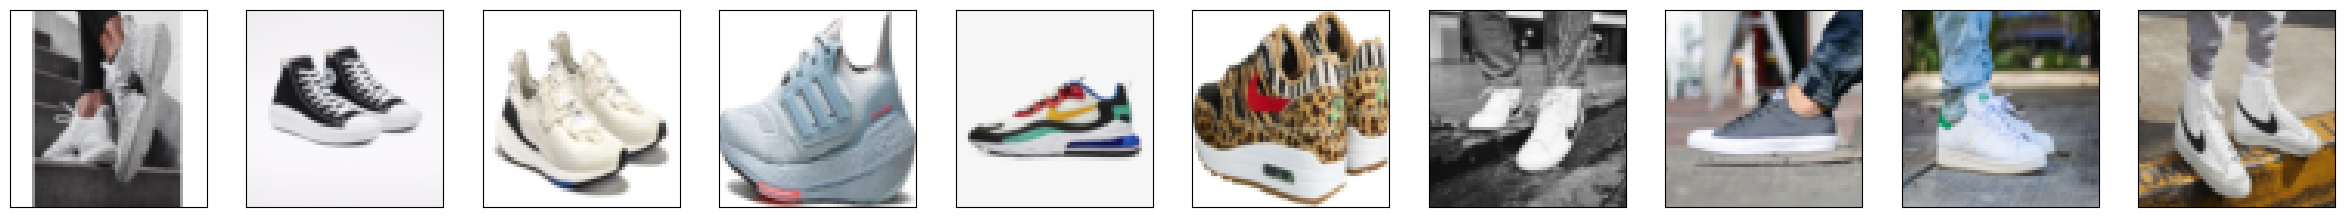

In [63]:
def RGBshow(img):
    img = img * 0.5 + 0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig = plt.figure(1, figsize=(30, 10))
for idx in range(10):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    RGBshow(normal_imgs[idx])

## Defining UNET

In [64]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


class DeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2):
        super().__init__()
        self.deConv = nn.ConvTranspose2d(in_channels, out_channels, size,
                                         padding=1, stride=2, output_padding=1)
        self.convs = ConvBlock(out_channels * 2, out_channels, size, padding, dropout)

    def forward(self, x, residual):
        x = self.deConv(x)
        x = torch.cat([x, residual], 1)
        x = self.convs(x)
        return x


class Unet(nn.Module):
    def __init__(self, d=64, out_channels=3, dropout=0.2):
        super().__init__()

        self.conv_blocks = nn.ModuleList([
            ConvBlock(3, d, dropout=dropout),
            ConvBlock(d, 2 * d, stride=2, dropout=dropout),
            ConvBlock(2 * d, 4 * d, stride=2, dropout=dropout),
            ConvBlock(4 * d, 8 * d, stride=2, dropout=dropout),
            ConvBlock(8 * d, 16 * d, stride=2, dropout=dropout)
        ])

        self.deConv_blocks = nn.ModuleList([
            DeConvBlock(16 * d, 8 * d, dropout=dropout),
            DeConvBlock(8 * d, 4 * d, dropout=dropout),
            DeConvBlock(4 * d, 2 * d, dropout=dropout),
            DeConvBlock(2 * d, d, dropout=dropout),
        ])

        self.output_conv = nn.Conv2d(d, out_channels, 3, padding=1)
        self.float()

    def forward(self, x):
        x1 = self.conv_blocks[0](x)
        x2 = self.conv_blocks[1](x1)
        x3 = self.conv_blocks[2](x2)
        x4 = self.conv_blocks[3](x3)
        x5 = self.conv_blocks[4](x4)

        x = self.deConv_blocks[0](x5, x4)
        x = self.deConv_blocks[1](x, x3)
        x = self.deConv_blocks[2](x, x2)
        x = self.deConv_blocks[3](x, x1)

        x = self.output_conv(x)

        return x

model = Unet()

## Loss Function and Optimizer

In [65]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training Process

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [67]:
epoch = 20
valid_loss_min = np.Inf

model.to(device)
history = {'train': [], 'valid': []}
for i in range(epoch):
    print(f'---- Epoch #{i+1}')

    model.train()
    sum_train_mse = 0
    training_steps = 0
    for (x, y), _ in tqdm(noisy_train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for (x, y), _ in tqdm(noisy_validation_loader):

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)

        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'UNET.pt')
        valid_loss_min = valid_loss

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Average Train MSE: {sum_train_mse / training_steps}\nAverage Validation MSE: {sum_valid_mse / valid_steps}')

---- Epoch #1


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (inf --> 9.067156). The new model saved
Average Train MSE: 0.4560598068767124
Average Validation MSE: 8.127521673838297
---- Epoch #2


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (9.067156 --> 4.943607). The new model saved
Average Train MSE: 0.27609457737869686
Average Validation MSE: 6.233863194783528
---- Epoch #3


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (4.943607 --> 0.247288). The new model saved
Average Train MSE: 0.22864486442671883
Average Validation MSE: 0.22475028534730276
---- Epoch #4


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.247288 --> 0.158986). The new model saved
Average Train MSE: 0.18936622142791748
Average Validation MSE: 0.14018941422303519
---- Epoch #5


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.158986 --> 0.087924). The new model saved
Average Train MSE: 0.1514818337228563
Average Validation MSE: 0.08743831018606822
---- Epoch #6


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.087924 --> 0.050428). The new model saved
Average Train MSE: 0.1102908162607087
Average Validation MSE: 0.049014886220296226
---- Epoch #7


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.050428 --> 0.027464). The new model saved
Average Train MSE: 0.07761767009894054
Average Validation MSE: 0.025647403672337532
---- Epoch #8


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.027464 --> 0.022989). The new model saved
Average Train MSE: 0.0626992794374625
Average Validation MSE: 0.02148115262389183
---- Epoch #9


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.022989 --> 0.020842). The new model saved
Average Train MSE: 0.05810884262124697
Average Validation MSE: 0.018541794270277023
---- Epoch #10


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.020842 --> 0.011542). The new model saved
Average Train MSE: 0.053311369899246425
Average Validation MSE: 0.013018914808829626
---- Epoch #11


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.047964568767282695
Average Validation MSE: 0.014872903004288673
---- Epoch #12


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.04301551522480117
Average Validation MSE: 0.012636333393553892
---- Epoch #13


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.04133636628588041
Average Validation MSE: 0.013620496727526188
---- Epoch #14


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.039507030612892576
Average Validation MSE: 0.014508616489668688
---- Epoch #15


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.011542 --> 0.010444). The new model saved
Average Train MSE: 0.03608553401297993
Average Validation MSE: 0.01116978656500578
---- Epoch #16


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.010444 --> 0.010068). The new model saved
Average Train MSE: 0.03279415725005998
Average Validation MSE: 0.011218794931968054
---- Epoch #17


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (0.010068 --> 0.008107). The new model saved
Average Train MSE: 0.03094656268755595
Average Validation MSE: 0.009505795004467169
---- Epoch #18


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.02991994573838181
Average Validation MSE: 0.010651892982423306
---- Epoch #19


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.02998853288590908
Average Validation MSE: 0.013202325130502382
---- Epoch #20


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Average Train MSE: 0.027230996638536453
Average Validation MSE: 0.013671099518736204


## Plotting Loss

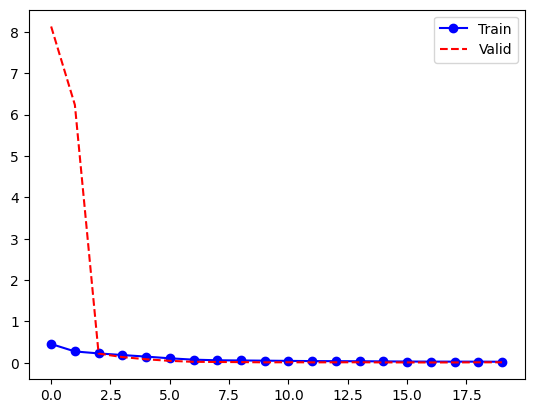

In [68]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

## Testing

In [69]:
model.eval()

with torch.no_grad():
    noise_imgs = noise_imgs.to(device)
    UNET_denoised_images = model(noise_imgs).cpu()

noise_imgs = noise_imgs.cpu()

## Compare The Results

In [71]:
def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if (mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2, window_size=11, sigma=1.5):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    gaussian_kernel = np.outer(
        np.exp(-np.square(np.arange(-(window_size // 2), window_size // 2 + 1)) / (2 * sigma**2)),
        np.exp(-np.square(np.arange(-(window_size // 2), window_size // 2 + 1)) / (2 * sigma**2))
    )
    gaussian_kernel /= gaussian_kernel.sum()

    def apply_filter(img, kernel):
        return gaussian_filter(img, sigma=sigma)

    mu1 = apply_filter(img1, gaussian_kernel)
    mu2 = apply_filter(img2, gaussian_kernel)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = apply_filter(img1**2, gaussian_kernel) - mu1_sq
    sigma2_sq = apply_filter(img2**2, gaussian_kernel) - mu2_sq
    sigma12 = apply_filter(img1 * img2, gaussian_kernel) - mu1_mu2

    numerator1 = 2 * mu1_mu2 + C1
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_map = (numerator1 * numerator2) / (denominator1 * denominator2)
    return np.mean(ssim_map)


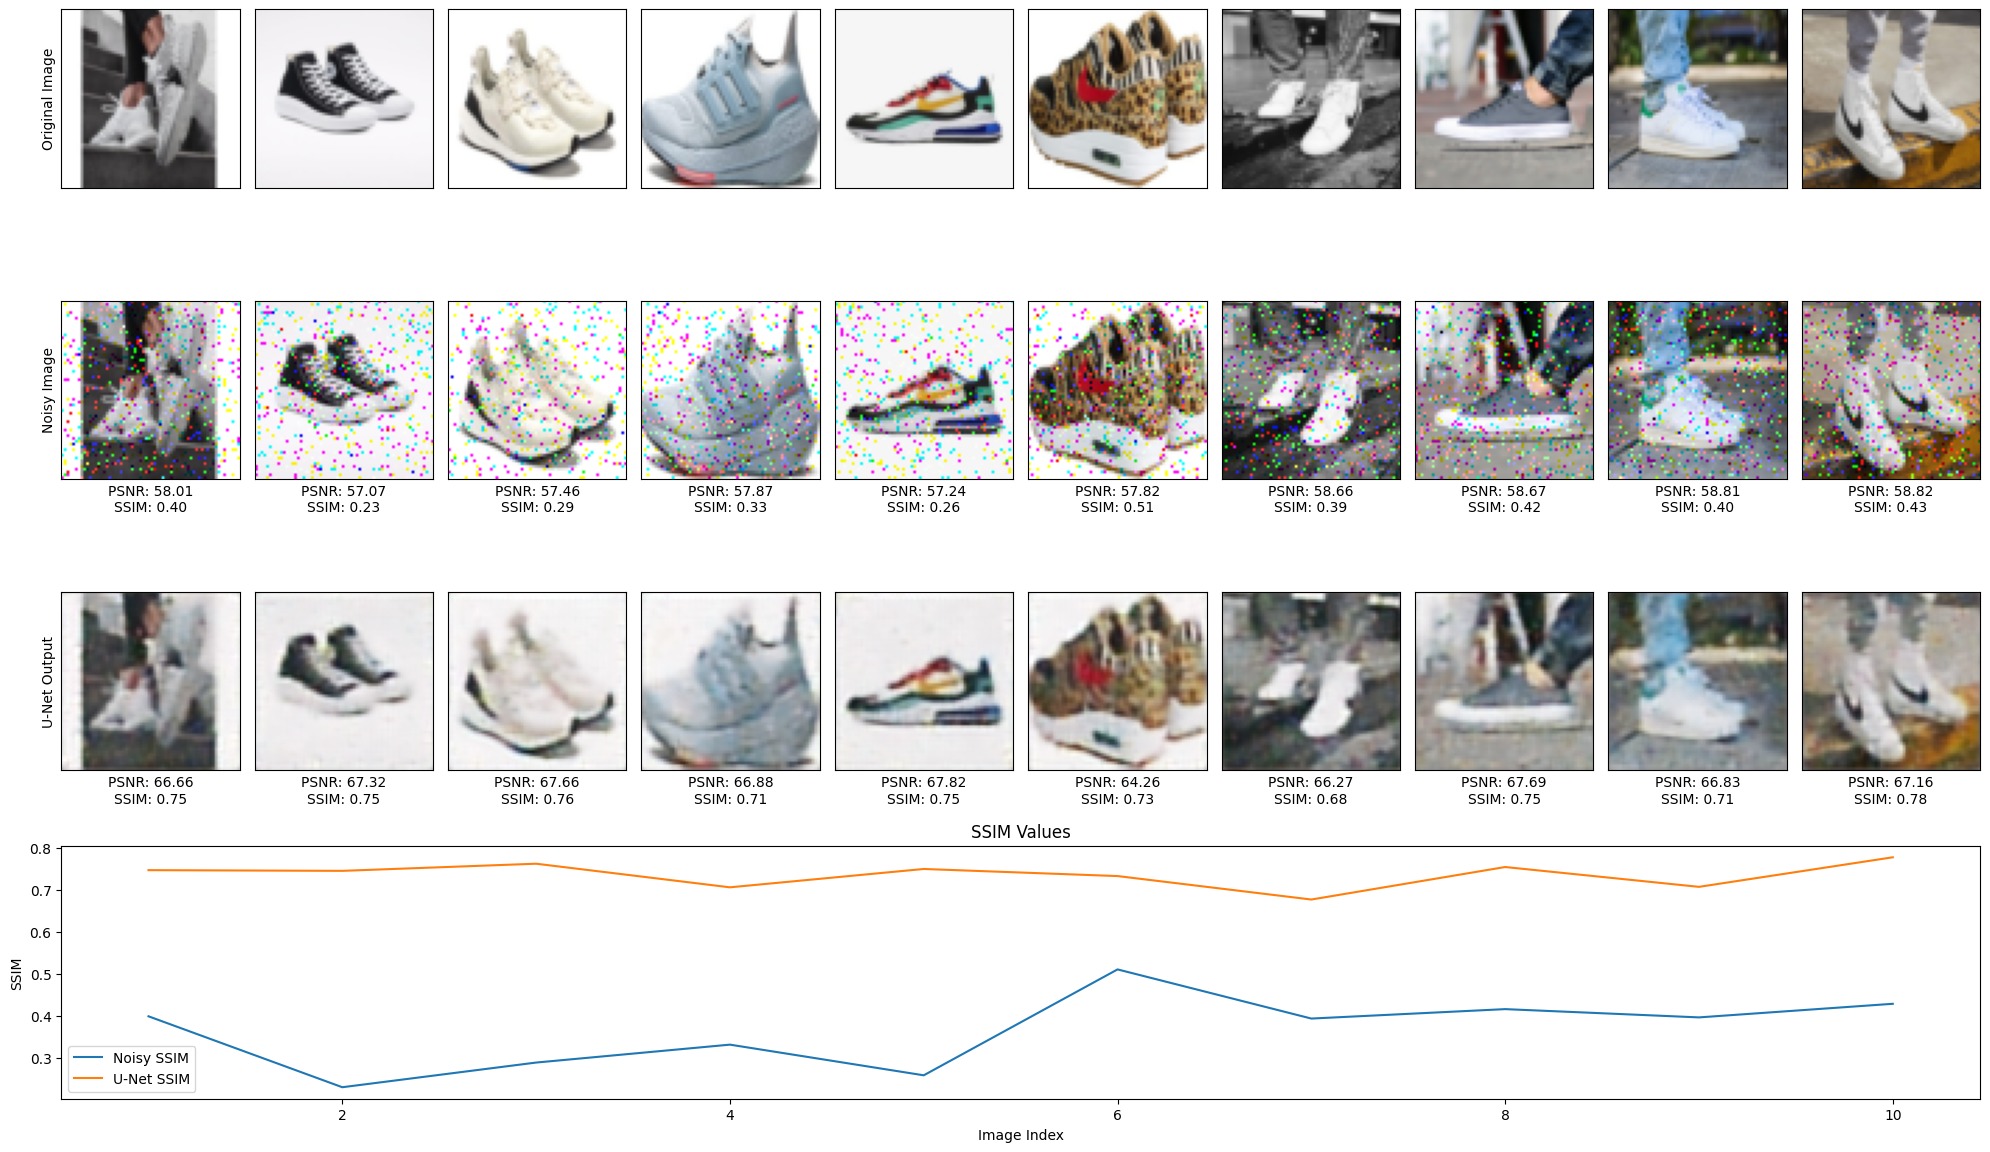

In [72]:
def RGBshow(img):
    img = img * 0.5 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

fig = plt.figure(1, figsize=(20, 12))

noise_ssim_values = []
unet_ssim_values = []

for index in range(10):
    noise_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())
    noise_ssim = calculate_ssim(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())

    unet_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), UNET_denoised_images[index].detach().cpu().numpy())
    unet_ssim = calculate_ssim(normal_imgs[index].detach().cpu().numpy(), UNET_denoised_images[index].detach().cpu().numpy())

    noise_ssim_values.append(noise_ssim)
    unet_ssim_values.append(unet_ssim)

    ax = fig.add_subplot(4, 10, index + 1, xticks=[], yticks=[])
    if index == 0:
        plt.ylabel('Original Image')
    RGBshow(normal_imgs[index])

    ax = fig.add_subplot(4, 10, index + 11, xticks=[], yticks=[])
    if index == 0:
        plt.ylabel('Noisy Image')
    plt.xlabel(f"PSNR: {noise_psnr:.2f}\nSSIM: {noise_ssim:.2f}")
    RGBshow(noise_imgs[index])

    ax = fig.add_subplot(4, 10, index + 21, xticks=[], yticks=[])
    if index == 0:
        plt.ylabel('U-Net Output')
    plt.xlabel(f"PSNR: {unet_psnr:.2f}\nSSIM: {unet_ssim:.2f}")
    RGBshow(UNET_denoised_images[index])

ax = fig.add_subplot(4, 1, 4)
plt.plot(range(1, 11), noise_ssim_values, label='Noisy SSIM')
plt.plot(range(1, 11), unet_ssim_values, label='U-Net SSIM')
plt.title('SSIM Values')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.legend()
plt.tight_layout()

plt.show()